In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
data=pd.read_csv('IMDB_Dataset.csv')

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## In the next step we will remove unwanted special characters

In [6]:
from bs4 import BeautifulSoup
import re

In [7]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
data['review']=data['review'].apply(denoise_text)

In [8]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
data['review']=data['review'].apply(remove_special_characters)

## Next we will label the data and split it into train and test and train LogisticRegression model

In [9]:
from sklearn.preprocessing import LabelBinarizer

In [10]:
lb=LabelBinarizer()
data['sentiment']=lb.fit_transform(data['sentiment'])

In [11]:
train_sentiment=data.sentiment[:40000]
train_review=data.review[:40000]
test_sentiment=data.sentiment[40000:]
test_review=data.review[40000:]

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [13]:
tf_vec=TfidfVectorizer(min_df=20,max_df=0.5,ngram_range=(1,2))

In [14]:
cv_train_review=tf_vec.fit_transform(train_review)
cv_test_review=tf_vec.transform(test_review)

In [15]:
#print(tf_vec.get_feature_names())

In [16]:
cv_train_review.shape,cv_test_review.shape

((40000, 60356), (10000, 60356))

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
lr=LogisticRegression()

In [19]:
model=lr.fit(cv_train_review,train_sentiment)

In [38]:
print('The score on the train data is:',model.score(cv_train_review,train_sentiment))

The accuracy on the train data is: 0.9455


In [39]:
print('The score on the test data is:',model.score(cv_test_review,test_sentiment))

The accuracy on the test data is: 0.9032


In [22]:
pred=model.predict(cv_test_review)

In [23]:
act=test_sentiment

In [24]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import matplotlib.pyplot as plt

In [25]:
confusion_matrix(act,pred)

array([[4480,  513],
       [ 455, 4552]], dtype=int64)

In [26]:
accuracy_score(act,pred)

0.9032

In [27]:
print(classification_report(act,pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4993
           1       0.90      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Here we categorize the sentiment of the comments in 5 positive and 5 negative categories

In [28]:
feature_to_coef = {
    word: coef for word, coef in zip(
        tf_vec.get_feature_names(), model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('great', 8.447827799635272)
('excellent', 6.371999122246557)
('perfect', 5.101749654002433)
('wonderful', 5.088938780580584)
('the best', 4.497882073239256)


In [29]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)
    

('bad', -9.241921602928585)
('worst', -8.43832825788847)
('awful', -7.044490189674085)
('the worst', -6.72490505565612)
('boring', -6.346466863431419)


In [30]:
pos_words=''
for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:100]:
    pos_words=pos_words+ str(best_positive)
    

In [31]:
neg_words=''
for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1])[:100]:
    neg_words=neg_words+ str(best_negative)

## Using wordcloud we will visualize most used positive and negative words

In [33]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

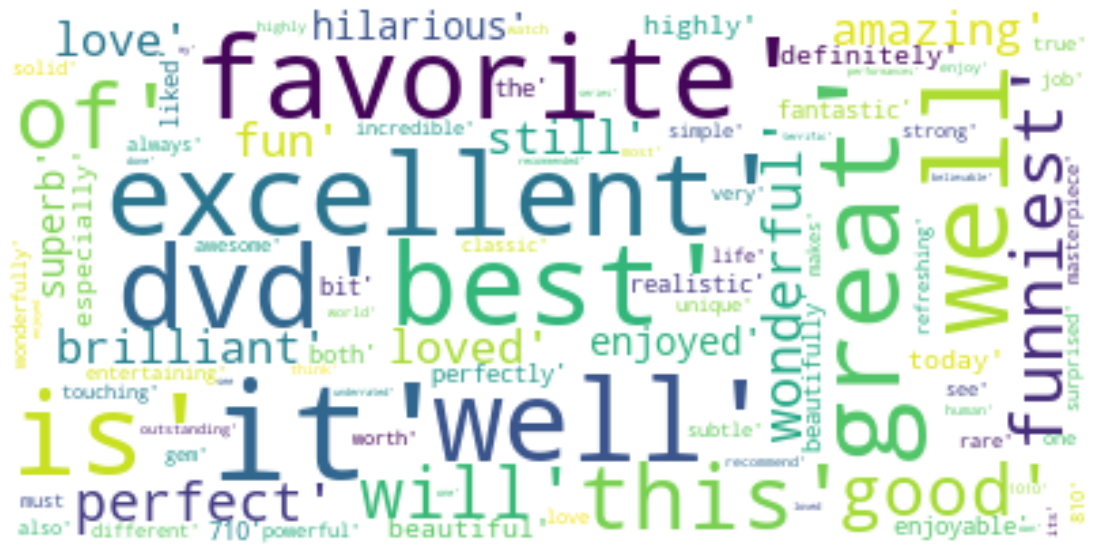

In [34]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_words)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

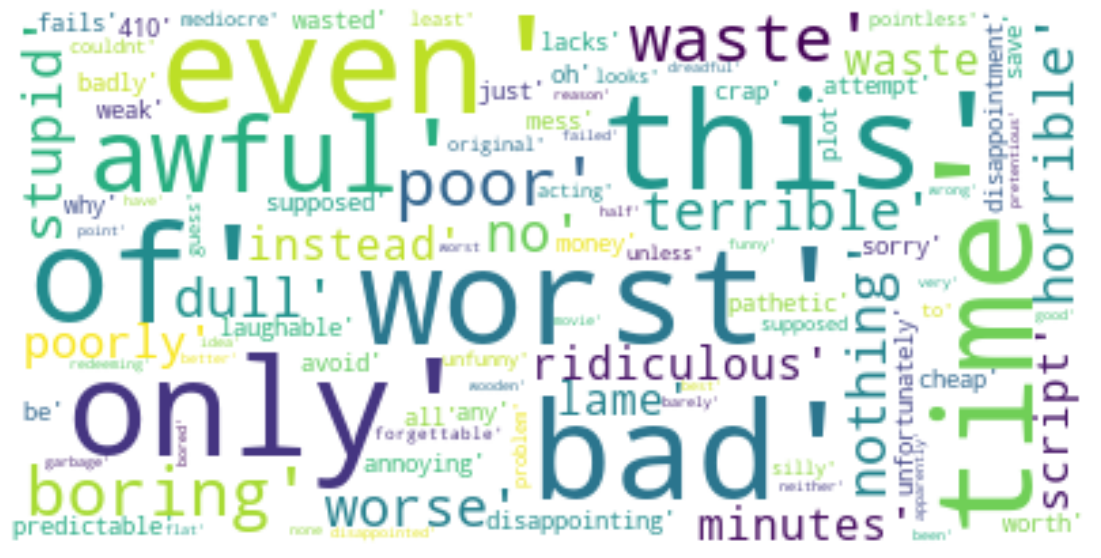

In [35]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_words)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()